In [728]:
# importamos las librerias
import tensorflow as tf
from fontTools.misc.timeTools import epoch_diff
from keras.src.ops import shape
from numpy.f2py.crackfortran import verbose
from pandas import get_dummies
from sklearn.datasets import load_iris
from tensorflow.keras import layers, models
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2, l1, l1_l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
#from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import (
    Accuracy,
    Precision,
    Recall,
    AUC,
    TruePositives,
    TrueNegatives,
    FalsePositives,
    FalseNegatives,
)
from tensorflow.python.eager.profiler_client import monitor
from tensorflow.python.keras.utils.version_utils import callbacks
from tensorflow.python.ops.gen_batch_ops import batch
from sklearn import datasets
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [729]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [730]:
# Paso 1: Extraemos el dataset y lo analizamos

# Extraccion de datos del dataset
dataset = datasets.load_iris()
x = dataset.data
y = dataset.target

# Convertir a dataframe para su representacion
dataframe = pd.DataFrame(x, columns = dataset.feature_names)
dataframe['target'] = dataset.target

# Para evitar overfitting le hace un barajado del dataset
dataframe=dataframe.sample(frac=1, random_state=42).reset_index(drop=True)  

dataframe.shape 

(150, 5)

In [731]:
# Mostramos el dataframe
dataframe

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,6.1,2.8,4.7,1.2,1
1,5.7,3.8,1.7,0.3,0
2,7.7,2.6,6.9,2.3,2
3,6.0,2.9,4.5,1.5,1
4,6.8,2.8,4.8,1.4,1
...,...,...,...,...,...
145,6.1,2.8,4.0,1.3,1
146,4.9,2.5,4.5,1.7,2
147,5.8,4.0,1.2,0.2,0
148,5.8,2.6,4.0,1.2,1


In [732]:
# Informacion resumida --> 4 variables independientes, 1 variable resultado con 150 registros y no nulos
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   target             150 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 6.0 KB


In [733]:
# Información general
dataframe.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


In [734]:
# Información sobre la salida
dataframe["target"].value_counts()

target
1    50
0    50
2    50
Name: count, dtype: int64

In [735]:
# Paso 2: Dividir el dataset: train, test, validacion
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0, stratify=y, shuffle=True)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.45, random_state=0, stratify=y_test, shuffle=True)

x_train.shape, x_test.shape, x_val.shape, y_train.shape, y_test.shape, y_val.shape

((112, 4), (20, 4), (18, 4), (112,), (20,), (18,))

In [736]:
# Paso 3: Estandarizamos el dataset (ya estan en label encoding la salida)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_val = scaler.transform(x_val)

x_train

array([[-1.01099825, -2.30005392, -0.15148942, -0.27585067],
       [-1.12773206, -0.08694362, -1.32740725, -1.32760471],
       [-1.71140115, -0.30825465, -1.32740725, -1.32760471],
       [-1.01099825, -1.63612083, -0.26348159, -0.27585067],
       [-1.12773206, -1.19349877,  0.40847146,  0.64443411],
       [ 0.50654139, -1.19349877,  0.6884519 ,  0.90737262],
       [ 0.50654139, -1.63612083,  0.35247537,  0.1185571 ],
       [-1.01099825,  1.01961153, -1.38340334, -1.19613545],
       [ 0.27307375, -0.52956568,  0.52046363, -0.01291216],
       [-1.01099825,  1.01961153, -1.21541508, -0.80172769],
       [-0.0771277 ,  2.12616668, -1.43939943, -1.32760471],
       [-0.31059534, -1.19349877,  0.07249493, -0.14438141],
       [-0.77753061,  0.7983005 , -1.32740725, -1.32760471],
       [-0.0771277 , -0.52956568,  0.74444798,  1.5647189 ],
       [-1.01099825,  0.7983005 , -1.21541508, -1.0646662 ],
       [-0.31059534, -0.30825465, -0.09549333,  0.1185571 ],
       [ 0.15633993, -0.

In [737]:
# Paso 4: Creamos el modelo (estructura neuronal)

modelo = models.Sequential([
    layers.Input(shape=(x_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    #layers.BatchNormalization(),
    layers.Dense(16, activation='relu'),
    #layers.BatchNormalization(),
    layers.Dense(8, activation='relu'),
    layers.Dense(3, activation='softmax'),
])
#early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
modelo.summary()

Model: "sequential_56"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_205 (Dense)               │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_206 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_207 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_208 (Dense)               │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 851 (3.32 KB)

 Trainable params: 851 (3.32 KB)

 Non-trainable params: 0 (0.00 B)

In [738]:
# Paso 5: Compilar el modelo --> necesitamos: funcion de coste (loss), funcion de backpropagation (optimizer + tasa de aprendizaje) y metricas
learning_rate= 0.001
optimizer= Adam(learning_rate=learning_rate)

modelo.compile(
    loss = SparseCategoricalCrossentropy(from_logits=False), # estamos con label encoding
    metrics = ["accuracy"],
    optimizer = optimizer
)

In [739]:
# Paso 6: Entrenamos el modelo
history = modelo.fit(x_train, y_train, epochs = 300, validation_data = (x_test, y_test),batch_size= 32,verbose = 1 )

Epoch 1/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.0750 - loss: 1.1817 - val_accuracy: 0.0500 - val_loss: 1.1097
Epoch 2/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1576 - loss: 1.1374 - val_accuracy: 0.3500 - val_loss: 1.0704
Epoch 3/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2707 - loss: 1.0951 - val_accuracy: 0.4000 - val_loss: 1.0390
Epoch 4/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4516 - loss: 1.0540 - val_accuracy: 0.6000 - val_loss: 1.0104
Epoch 5/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6411 - loss: 1.0155 - val_accuracy: 0.7000 - val_loss: 0.9851
Epoch 6/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7324 - loss: 0.9817 - val_accuracy: 0.7500 - val_loss: 0.9590
Epoch 7/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8152 - loss: 0.9509 - val_accuracy: 0.7500 - val_loss: 0.9348
Epoch 8/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8060 - loss: 0.9264 - val_accuracy: 0.7500 - val_loss: 0.9141

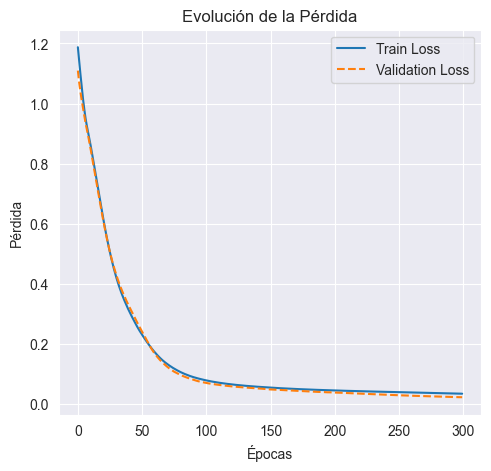

In [740]:
# Paso 7: Grafica de perdida
history_dict = history.history  
  
# Pérdida (loss)  
plt.figure(figsize=(12, 5))  
plt.subplot(1, 2, 1)  
plt.plot(history_dict['loss'], label='Train Loss')  
plt.plot(history_dict['val_loss'], label='Validation Loss', linestyle='--')  
plt.title('Evolución de la Pérdida')  
plt.xlabel('Épocas')  
plt.ylabel('Pérdida')  
plt.legend()

In [741]:
# Paso 8: Evaluamos el modelo
test_loss, test_accuracy = modelo.evaluate(x_test, y_test, verbose=0)
print(f"Loss en prueba: {test_loss}")
print(f"Accuracy en prueba: {test_accuracy}")

print("*******************************")
test_loss, test_accuracy = modelo.evaluate(x_val, y_val, verbose=0)
print(f"Loss en validacion: {test_loss}")
print(f"Accuracy en validacion: {test_accuracy}")

Loss en prueba: 0.023026520386338234
Accuracy en prueba: 1.0
*******************************
Loss en validacion: 0.0257782693952322
Accuracy en validacion: 1.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


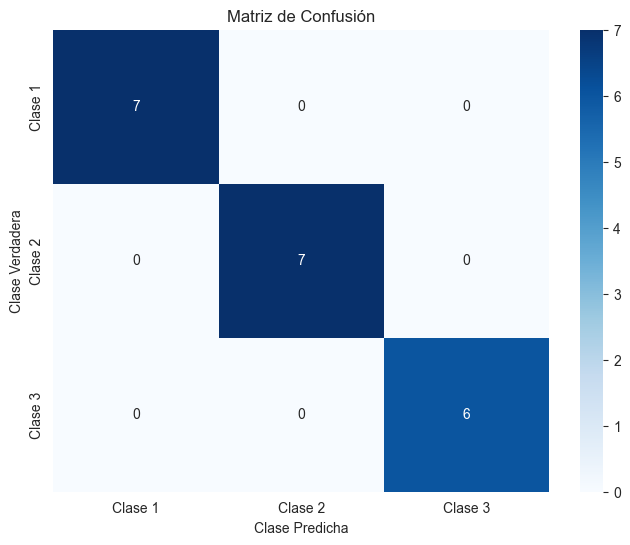


Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         7
           1     1.0000    1.0000    1.0000         7
           2     1.0000    1.0000    1.0000         6

    accuracy                         1.0000        20
   macro avg     1.0000    1.0000    1.0000        20
weighted avg     1.0000    1.0000    1.0000        20



In [742]:
# Predicciones con el de validacion  
y_pred_probs = modelo.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1) 
y_true = y_test
  
# Matriz de confusión  
conf_matrix = confusion_matrix(y_true, y_pred) 

# Cramos un heatmap con seaborn
plt.figure(figsize=(8, 6))  
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 1', 'Clase 2', 'Clase 3'], yticklabels=['Clase 1', 'Clase 2', 'Clase 3'])  
plt.title('Matriz de Confusión')  
plt.xlabel('Clase Predicha')  
plt.ylabel('Clase Verdadera')  
plt.show()  
  
# Métricas de clasificación  
print("\nClassification Report:")  
print(classification_report(y_true, y_pred, digits=4))